In [ ]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


#***SAM***
Nel codice seguente viene clonata la repo git di SAM e caricati i suoi pesi. \\
L'isallazione di *supervision* serve per poter stampare tutte le maschre qual'ora sia necessario.


In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
import supervision as sv

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qr9rq_rj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qr9rq_rj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=02e84aca8ffc26a5b775a200601fad403572672264402f51056b903edc23ac32
  Stored in directory: /tmp/pip-ephem-wheel-cache-yjvjjtfi/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-09-08 14:40:50--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.50, 13.35

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import nibabel as nib

Le due funzioni di seguito servono per stamapre le immagini e per vedere l'immagine con le maschere poste al di sopra.

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show(img1, img2):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  axes[0].imshow(img1, cmap='gray')
  axes[0].axis('off')
  axes[0].set_title("Immagine Originale", fontsize = 15)
  axes[1].imshow(img2, cmap='gray')
  axes[1].axis('off')
  axes[1].set_title("Immagine Modificata", fontsize = 15)
  plt.show()

Nel codice seguetne si importa la funzione di generazione automatica di msschere di Sam, impostando il device a "cuda" per aumentarne le prestazioni e settando chekpoint e tipo di modello.\
Sono stati impostati dei parametri per SAM.

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# Spiegazione codice
Sono presenti quattro **cicli for**:
1. *for dir in directorys.iterdir()*: serve per scorrere tutte le cartelle all'interno di directorys ch erappresenta la cartella contenente i file Ninfty.
2. *for image in dir.iterdir()*: serve per selezionare le immagini all'interno della cartella corrente.
3. *for slices in range(255)*: una volta ottenuta l'immagine bisogna considerare solo la sezione **axial** e da ogni sezzione si ottengono 255 **slices**, questo ciclo for serve per poterle elaborare tutte.
4. *for i in range(len(filtered_masks))*: ottenute le maschere della Slice corrente e dopo averle ordiante per area in modo decrescente ed aver eliminato le aree con area minore di 50, vengono salvate all'interno dell'apposita cartella con il seguente formato per il nome {**ID Immagine**}_slice{**numero della slice**}_{**numero della maschera**}.png"

Ulteriori spiegazioni:
*   **try/exceot**: utilizzato per la creazione della cartella delle maschere. Nel caso in cui già la cartella è esistente, vuol dire che sono già state elaborate le maschere e quindi si passa alla successiva.
*  Il codice seguente serve per poter trasformare la slice in un'immagine 3d a scala di grigi adatta all'elaborazione per SAM. Sottraendo 255 a ogni elemento rendiamo l'immagine ottenuta simile all'originale, la quale altrimenti sarebbe troppo bianca. In questo modo i bordi e rilievi sono più evidente e Sam riesce a rilevare meglio le differenze tra le regioni di cervello.
        image = data[:, :, slices][:, :, np.newaxis]
        image = np.repeat(image, 3, axis=2)
        image = 255 - (255 * (image.max() - image) / (image.max() - image.min())).astype(np.uint8)
* Per poter ordinare le maschere generate si è optato per effettuare un sort in modo da avere le maschere dalla più grande alla più piccola e poi sono state eliminate le maschere con l'area inferiroe a 50.
      sort_mask = sorted(masks, key=lambda x: x['area'], reverse=True)
      filtered_masks = [mask for mask in sort_mask if mask['area'] >= 50]
* Una volta ottenute le maschere idonee al salvataggio si seleziona il tensore contenente la maschera, sotto la voce "**segmentation**", si ottiene un tensore da un numpy si effettuano delle coversione e si permutano le dimensioni del tensore per poter avere **larghezza, altezza, canali**.
Tramite **Open CV(cv2)** si salva il tensore come un'immagine png, nel path designato.
        img_np = (filtered_masks[i]['segmentation'])
        img_tt = torch.from_numpy(img_np)
        img_tt = img_tt[None, : ]
        img = img_tt.long().type(torch.uint8)
        mask_name = f"{image_ID}_slice{slices}_{i}.png"
        tensor = img.permute(1, 2, 0)
        array = tensor.numpy()
        cv2.imwrite(dirPath / mask_name, array)
* *Chek*:
Questa funnzione serve per far ripartire SAM dalla slice dell'immagine corretta senza fargli ricalcolare per ogni immagine tutte le slice qual'ora si bloccasse il codice


In [ ]:
def Chek(path):
  val = 0
  for img in path.iterdir():
    n_slice = str(img).split("_")[-2].split("e")[1]
    if int(n_slice) > val:
      val = int(n_slice)

  return val

In [ ]:
directorys = Path("/content/drive/MyDrive/Colab_Notebooks/Tesi/Images/Image_NiFTY/")
for dir in directorys.iterdir():
  #print(dir)
  for Image in dir.iterdir():
    #print(Image)
    image_ID = str(Image).split('/')[-1].split('.')[0]
    print(image_ID)
    dirPath = Path('/content/drive/MyDrive/Colab_Notebooks/Tesi/Images/Image_Mask') / image_ID
    chek = Chek(dirPath)
    print(chek)

    try:
      dirPath.mkdir()
    except FileExistsError:
      print(f"La cartella {dirPath} esiste già")

    nifti_path = str(Image)
    nifti_image = nib.load(nifti_path)
    data = nifti_image.get_fdata()
    #slices = []
    for slices in range(255):
      if slices >= chek:
        #slices.append(data[:, :, i])

        image = data[:, :, slices][:, :, np.newaxis]
        # Espandi la terza dimensione copiando i valori
        image = np.repeat(image, 3, axis=2)
        #print(image.shape,image)
        image = 255 - (255 * (image.max() - image) / (image.max() - image.min())).astype(np.uint8)

        #show(data[:, :, slices], image)

        print(f"Calcolo maschere della slice n°{slices}")
        masks = mask_generator.generate(image)
        print(len(masks))
        sort_mask = sorted(masks, key=lambda x: x['area'], reverse=True)
        filtered_masks = [mask for mask in sort_mask if mask['area'] >= 50]
        print(len(filtered_masks))
        for i in range(len(filtered_masks)):

          img_np = (filtered_masks[i]['segmentation'])
          img_tt = torch.from_numpy(img_np)
          img_tt = img_tt[None, : ]

          img = img_tt.long().type(torch.uint8)

          mask_name = f"{image_ID}_slice{slices}_{i}.png"
          print(mask_name)

          tensor = img.permute(1, 2, 0)
          array = tensor.numpy()
          cv2.imwrite(str(dirPath / mask_name), array)



I1221051
150
La cartella /content/drive/MyDrive/Colab_Notebooks/Tesi/Images/Image_Mask/I1221051 esiste già
Calcolo maschere della slice n°150
32
22
I1221051_slice150_0.png
I1221051_slice150_1.png
I1221051_slice150_2.png
I1221051_slice150_3.png
I1221051_slice150_4.png
I1221051_slice150_5.png
I1221051_slice150_6.png
I1221051_slice150_7.png
I1221051_slice150_8.png
I1221051_slice150_9.png
I1221051_slice150_10.png
I1221051_slice150_11.png
I1221051_slice150_12.png
I1221051_slice150_13.png
I1221051_slice150_14.png
I1221051_slice150_15.png
I1221051_slice150_16.png
I1221051_slice150_17.png
I1221051_slice150_18.png
I1221051_slice150_19.png
I1221051_slice150_20.png
I1221051_slice150_21.png
Calcolo maschere della slice n°151
36
22
I1221051_slice151_0.png
I1221051_slice151_1.png
I1221051_slice151_2.png
I1221051_slice151_3.png
I1221051_slice151_4.png
I1221051_slice151_5.png
I1221051_slice151_6.png
I1221051_slice151_7.png
I1221051_slice151_8.png
I1221051_slice151_9.png
I1221051_slice151_10.png
I12210

# PER VISUALIZZARE

In [ ]:
from torchvision.io import read_image

In [ ]:
path_DIR = Path("/content/drive/MyDrive/Colab_Notebooks/Tesi/Images/Image_Mask/I1221051")
prova = read_image("/content/drive/MyDrive/Colab_Notebooks/Tesi/Images/Image_Mask/I1221051/I1221051_slice0_2.png")
prova = prova.permute(1,2,0)

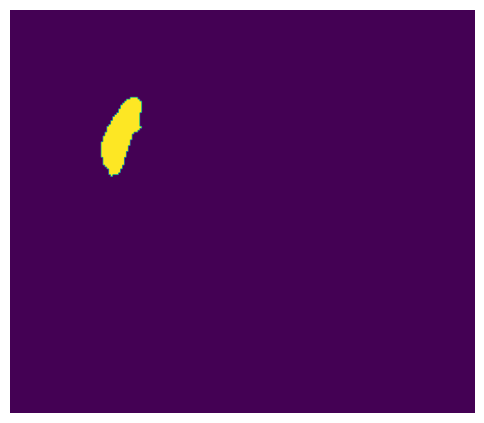

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(prova)
plt.axis('off')
plt.show()